#Load Libraries & Dataset

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


## Load Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

fp= "/content/drive/MyDrive/Snowy Plover Datasets/cleaned_plover_dataset.csv"
plover = pd.read_csv(fp)

plover.head()

Mounted at /content/drive


,ID,SNPL_Data_ID,Event_ID,Type,Basis_Of_Record,Unit_Code,Location_ID,Loc_Code,Loc_Name,Start_Year,...,Eggs,Hatchlings,Fledglings,Failure_Reason,Predator_Type,Restored_Area,NestSuccess,NumChicks_Banded,MeanChickWeight_g,Pct_Chicks_EggTooth
0,11975,002b83c1-799d-42da-9541-9d9c992478c9,90d84c98-4f70-4b19-b352-cd2bd3bfc5f4,event,HumanObservation,PORE,{764DC5D8-DDE7-49E6-B146-A9328A9BB8B6},NP,North Beach - Abbott's,2024,...,0,0,0,Unknown,Unknown,False,False,0,5.95,0.666667
1,11976,00340134-705e-4198-ad1e-9bfc43975747,c0a296b4-bb93-4590-bd71-d266d11bf92f,event,HumanObservation,PORE,{39744D68-DFEE-4649-ACE2-806C077E64E2},K,Kehoe Beach,2024,...,3,0,0,Abandoned,Unknown,False,False,0,5.95,0.666667
2,11977,0069b16d-7ac7-4dd1-ab64-7d8bf0b78253,28acd5fd-a864-4fcd-8b7c-22b7c69303e8,event,HumanObservation,PORE,{AAECB23A-DD1B-4289-A95D-BD34276088B9},L,Limantour Beach,2024,...,0,0,0,Unknown,Unknown,False,False,0,5.95,0.666667
3,11978,009a573e-6fea-4530-a1d9-45ee805724db,54c059e0-b000-400c-a65b-088a9a8f52de,event,HumanObservation,PORE,{EE76E19D-DBD4-4FCB-9151-C32719F25BD9},DB,Drakes Beach,2024,...,3,3,2,Unknown,Unknown,False,True,2,5.95,1.000000
4,11979,00a3abd1-648e-48e3-b18d-308daf1a850f,ac9aeeca-4178-4d8b-ab4a-71cf66ba3fbb,event,HumanObservation,PORE,{764DC5D8-DDE7-49E6-B146-A9328A9BB8B6},NP,North Beach - Abbott's,2024,...,3,3,2,Unknown,Unknown,False,True,2,5.95,1.000000


# Dataset Overview


*   Final cleaned dataset contains 13,220 rows and 71 columns
*   Includes a mix of boolean, numeric, and categorical variables
* Key ecological features include plovers observed, predator information, nest outomes, environmental conditions, and temporal + spatial attributes



In [4]:
plover.info()
plover.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13220 entries, 0 to 13219
Data columns (total 71 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   13220 non-null  int64  
 1   SNPL_Data_ID         13220 non-null  object 
 2   Event_ID             13220 non-null  object 
 3   Type                 13220 non-null  object 
 4   Basis_Of_Record      13220 non-null  object 
 5   Unit_Code            13220 non-null  object 
 6   Location_ID          13220 non-null  object 
 7   Loc_Code             13220 non-null  object 
 8   Loc_Name             13220 non-null  object 
 9   Start_Year           13220 non-null  int64  
 10  Start_Date           13220 non-null  object 
 11  Nest_ID              5506 non-null   object 
 12  SNPL_Time            13134 non-null  object 
 13  SNPL_Time_Local      13134 non-null  object 
 14  Local_Time_Zone      13134 non-null  object 
 15  QCFlag               1787 non-null  

,0
ID,0
SNPL_Data_ID,0
Event_ID,0
Type,0
Basis_Of_Record,0
...,...
Restored_Area,0
NestSuccess,0
NumChicks_Banded,0
MeanChickWeight_g,0


## Explanatory Data Analysis for Target: Predator_Present


####Predator Presence By Month


*   Peaks sharply from May --> July, which aligns with core nesting season
*   Very low predator activity occurs early (March) and late August - September
* For machine learning models --> Month is a strong seasonal predictor for predator presence and should be kept
* Seasonal patterns imply that predator activity isn't random, it's tied to ecological cycles

####Predator Presence By Location
* Certain beaches account for the majority of predator detections
* Several other locations show minimal predator activity, showing location specific ecological pressurs
* For machine learning models --> Loc_name is an important categorical feature and should be one-hot encoded
* Use location based dummy variables since it will add predictive power

####Distribution of Predator_Present (Target Variable)


*   Dataset is moderately imbalanced (71% target, 29% absent)
*   Class imbalance shows that class_weight options should be explored in logistic regression moldel






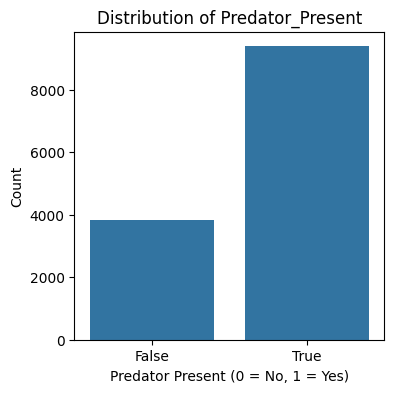

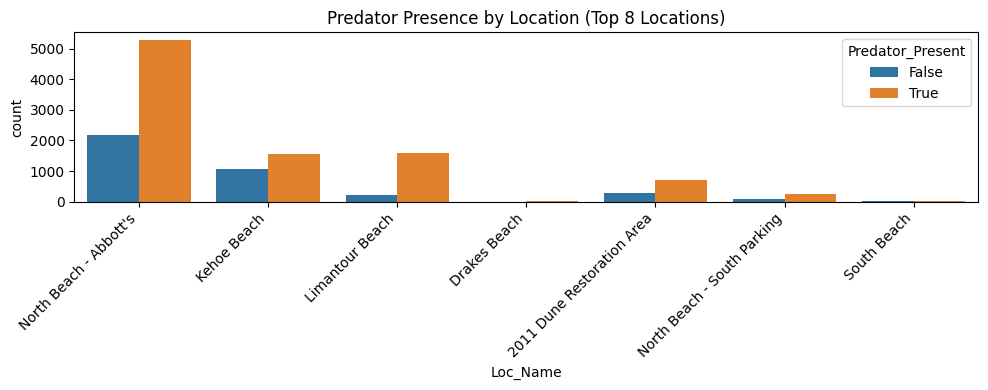

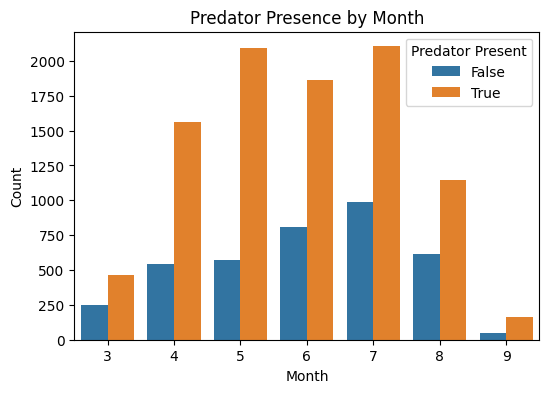

In [5]:

# Check target distribution
plt.figure(figsize=(4,4))
sns.countplot(x="Predator_Present", data=plover)
plt.title("Distribution of Predator_Present")
plt.xlabel("Predator Present (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# location relationship w/target variable
plt.figure(figsize=(10,4))
top_locs = plover["Loc_Name"].value_counts().nlargest(8).index
sns.countplot(
    data=plover[plover["Loc_Name"].isin(top_locs)],
    x="Loc_Name",
    hue="Predator_Present"
)
plt.xticks(rotation=45, ha="right")
plt.title("Predator Presence by Location (Top 8 Locations)")
plt.tight_layout()
plt.show()

# month relationship w/ target variable
plt.figure(figsize=(6,4))
sns.countplot(x="Month", hue="Predator_Present", data=plover)
plt.title("Predator Presence by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend(title="Predator Present")
plt.show()


# Select Features and Split Data

#### Choosing Target Variable
*   We chose Predator_Present as the target variable because its the most consistent and interpretable ecological feature in the dataset
* recorded for every observation, so it's good for supervised ML
*   Tied to the purpose of our project which is to see how predators affect plovers and where/when predators are most active
* Risk inidicator for snowy plovers

#### Choosing Specific Feature Set
* EDA showed strong relationships between predator presence and seasonal variables, spatial, and weather conditions

#### Train/test Split
* Used stratified split because the target variable is imbalanced
* Ensures that both train and test split reflect true class proportions




In [16]:
# Our target variable is Predator_Present because it's a risk indiactor for Snowy Plovers

# Make sure that the target variable is numeric 0/1
plover["Predator_Present"] = plover["Predator_Present"].map(
    {True: 1, False: 0, "True": 1, "False": 0}
    ).fillna(plover["Predator_Present"]).astype(int)

target_col = "Predator_Present"

# feature set based on eda
feature_cols = [
    "Month",
    "DayOfYear",
    "Loc_Name",
    "Total_SNPL",
    "SNPL_Male",
    "SNPL_Female",
    "SNPL_Unk",
    "SNPL_Hatchlings",
    "SNPL_Fledglings",
    "Wind_Spd_mph",
    "Wind_Max_mph",
    "Air_Temp_degF",
    "Rel_Hum_per",
    "Cloud_Cover",
    "Tide_Cond",
    "Survey_Direction",
]

ml_df = plover[feature_cols + [target_col]].copy()


In [17]:
## HANDLE MISSING VALUES + BASIC CLEANING --> Only Cloud_Cover has missing values, so it will be handled

numeric_features = [
    "Total_SNPL",       # total plovers counted
    "Air_Temp_degF",
    "Rel_Hum_per",
    "Cloud_Cover",      # cloud cover (0–8 or similar)
    "Wind_Spd_mph",
    "Wind_Max_mph"
]

categorical_features = [
    "Loc_Name",
    "Month",
    "Tide_Cond",        # tide condition
    "Survey_Direction"  # survey direction
]

print(ml_df.isnull().sum())

# fill Cloud Cover with median
if ml_df["Cloud_Cover"].isnull().sum() > 0:
    cloud_median = ml_df["Cloud_Cover"].median()
    ml_df["Cloud_Cover"] = ml_df["Cloud_Cover"].fillna(cloud_median)

#verify that it worked

print(ml_df.isnull().sum())

Month                 0
DayOfYear             0
Loc_Name              0
Total_SNPL            0
SNPL_Male             0
SNPL_Female           0
SNPL_Unk              0
SNPL_Hatchlings       0
SNPL_Fledglings       0
Wind_Spd_mph          0
Wind_Max_mph          0
Air_Temp_degF         0
Rel_Hum_per           0
Cloud_Cover         339
Tide_Cond             0
Survey_Direction      0
Predator_Present      0
dtype: int64
Month               0
DayOfYear           0
Loc_Name            0
Total_SNPL          0
SNPL_Male           0
SNPL_Female         0
SNPL_Unk            0
SNPL_Hatchlings     0
SNPL_Fledglings     0
Wind_Spd_mph        0
Wind_Max_mph        0
Air_Temp_degF       0
Rel_Hum_per         0
Cloud_Cover         0
Tide_Cond           0
Survey_Direction    0
Predator_Present    0
dtype: int64


In [18]:
## TRAIN/TEST SPLIT (stratified) to keep proportion of predators similar in both sets

# Filter to only the columns we need
used_cols = numeric_features + categorical_features + [target_col]
ml_df_model = ml_df[used_cols].dropna(subset=[target_col])

X = ml_df_model.drop(columns=[target_col])
y = ml_df_model[target_col].astype(int)

print("X shape:", X.shape)
print("Class balance (0 = no predator, 1 = predator):")
print(y.value_counts(normalize=True))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 42, stratify=y)

X_train.shape, X_test.shape, y_train.value_counts(), y_test.value_counts()

X shape: (13220, 10)
Class balance (0 = no predator, 1 = predator):
Predator_Present
1    0.710514
0    0.289486
Name: proportion, dtype: float64


((10576, 10),
 (2644, 10),
 Predator_Present
 1    7514
 0    3062
 Name: count, dtype: int64,
 Predator_Present
 1    1879
 0     765
 Name: count, dtype: int64)

# Feaure Engineering + Encoding


####Numeric pipeline
*   Used median imputation because many numeric features contain missing valyes and median is good for handling outliers commonly found in ecological data
* Standard scaler normalizes numeric features to a similar scale which is good for the ML models we wanted to use so we can avoid bias toward larger scaled variables
* Combines all numeric preprocessing into one pipeline, ensuring same scaling is applied to both training and test set

####Categorical Pipeline


*   Used most frequent imputation for the Simple Imputer
*   One hot encoding was used because it lets our ML model capture location specific and condition specific predator patterns


####Column Transformer
* Combines both pipelines into a single step so it's reproducible for all our models
* We prevented data leakage through fitting the imputer and scaler only on the training data




In [19]:
# Numeric pipeline: median imputation + standard scaling
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline: most frequent imputation + one-hot
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Logistic Regression Model


*   Chose it because it's used for binary classification, which matches our target variable
* Helps to understand which environmental + behavioral attributes increase the probability of predator sightings
*   Baseline model and can be compared against more complex models
* Performs reliably with scaled numeric features



In [32]:
log_reg = LogisticRegression(max_iter=5000, random_state=42)

pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", log_reg) #Using existing pipeline
])


param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs", "liblinear"],
    "clf__class_weight": [None, "balanced"]
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    refit=True
)


grid_search.fit(X_train, y_train)

print("Best parameters for Logistic Regression:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

best_log_model = grid_search.best_estimator_

Best parameters for Logistic Regression: {'clf__C': 0.1, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV accuracy: 0.8447435949000524


## Logistic Regression Metrics + Visualizations


*   Achieved 84% accuracy --> strong predicitve ability, but could be better (which is why we used more complex models)
*   High recall of 0.97 --> model is good at identifying predator present events
* Precision of 0.83 shows predicted predator events were correct, but not as strong as the future models
* F1 of 0.896 shows a good balance between precision and recall
* Model struggles with the minority class because of the imbalance

####ROC Curve
* The curve rises steeply towards the top left, showing strong true positive rates
AUC score of 0.84 shows it can distingush between predator vs non predator events 84% of the time

Best parameters for Logistic Regression: {'clf__C': 0.1, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV accuracy: 0.8447435949000524

Logistic Regression – Test Performance (threshold = 0.5)
Accuracy:  0.8392586989409985
Precision: 0.8307552320291174
Recall:  0.9717935071846727
F1:  0.895756683836154
AUC:  0.840361477214622
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.51      0.65       765
           1       0.83      0.97      0.90      1879

    accuracy                           0.84      2644
   macro avg       0.86      0.74      0.77      2644
weighted avg       0.85      0.84      0.82      2644



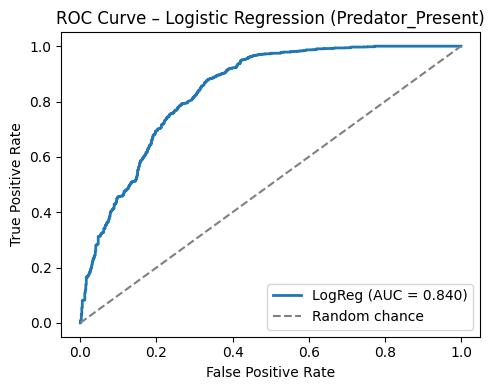

In [33]:
best_log = grid_search.best_estimator_

print("Best parameters for Logistic Regression:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)


y_pred = best_log.predict(X_test)
y_proba = best_log.predict_proba(X_test)[:, 1]

# Metrics on the test set
print("\nLogistic Regression – Test Performance (threshold = 0.5)")
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))

auc_score = roc_auc_score(y_test, y_proba)
print("AUC: ", auc_score)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC curve visualization
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, linewidth=2, label=f"LogReg (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression (Predator_Present)")
plt.legend()
plt.tight_layout()
plt.show()


# Random Forest Classifier



*   We chose this as the next model because it's able to handle more complex patterns
*   Automaically captures nonlinear patterns better than previous model
* Works well with mixed feature types & provides feature importance which can tell us which ecological conditions most strongly predict predator presence




## Separate numeric and categorical features

In [22]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

Numeric features: ['Total_SNPL', 'Air_Temp_degF', 'Rel_Hum_per', 'Cloud_Cover', 'Wind_Spd_mph', 'Wind_Max_mph', 'Month']
Categorical features: ['Loc_Name', 'Tide_Cond', 'Survey_Direction']


## Pipelines

In [23]:
numeric_pipeline_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())  #Scaling not necessary but just in case
])

categorical_pipeline_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline_rf, numeric_features),
        ("cat", categorical_pipeline_rf, categorical_features)
    ]
)

rf_clf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocessor_rf),
    ("rf", rf_clf)
])

## Hyperparameters + Model


*   Good accuracy (96.6%) and recall (99.2%) for predators
* The model is extremely effective at catching predator-present events, which helps with plover risk detection
* Stable and generalizable --> Cross-validation accuracy (≈0.96) closely matches test accuracy, meaning the model is not overfitting



In [24]:
rf_param_grid = {
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [None, 10, 20],
    "rf__min_samples_split": [2, 5],
    "rf__min_samples_leaf": [1, 2],
    "rf__max_features": ["sqrt", "log2"]
}

rf_grid = GridSearchCV(
    rf_pipe,
    param_grid=rf_param_grid,
    cv=5, # 5 fold cross validation
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

print("Fitting Random Forest GridSearchCV...")
rf_grid.fit(X_train, y_train)

# Choose best parameters and CV accuracy
rf_best = rf_grid.best_estimator_
print("Best parameters for Random Forest:", rf_grid.best_params_)
print("Best CV accuracy (Random Forest):", rf_grid.best_score_)

# 6. Evaluate on the test set
y_pred_rf = rf_best.predict(X_test)
y_proba_rf = rf_best.predict_proba(X_test)[:, 1]

print("Random Forest – Test Performance (threshold = 0.5)")
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_prec = precision_score(y_test, y_pred_rf)
rf_rec = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_proba_rf)

Fitting Random Forest GridSearchCV...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for Random Forest: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best CV accuracy (Random Forest): 0.9614224170677537
Random Forest – Test Performance (threshold = 0.5)


## Confusion Matrix, ROC Curve, Feature Importance

#### Confusion Matrix


*   True Positives of 1,865 —-> Predator present correctly labeled as present
* True Negatives of 689 -->  No predator correctly identified

* False Positives of 76 --> Said predator was present even though none were seen

* False Negatives of 14 --> Missed predator-present cases

* The model rarely misses predator events, so it's a strong outcome

####ROC Curve
* ROC curve hugs the top-left corner —--> showing the model maintains a very high true positive rate even at low false positive rates

* AUC = 0.983 —-> signifies exceptional discriminative power.

* Outperforms linear model since the Logistic regression flattened earlier, but the Random Forest continues improving across thresholds

####Feature Importance
* The top predictors include
* Survey_Direction_Unknown (13%) --> indicates when survey direction was not properly recordered, so predators were often present possibly because of hurried observations
* Temperature, cloud cover, wind speeds (9-10%) --> weather conditions strongly correlate with predator movement
* Relative humidity + month (5-9%) --> predator is seasonal and tied to moisture levels, peak predator presence is in late spring and early summer



<Figure size 400x400 with 0 Axes>

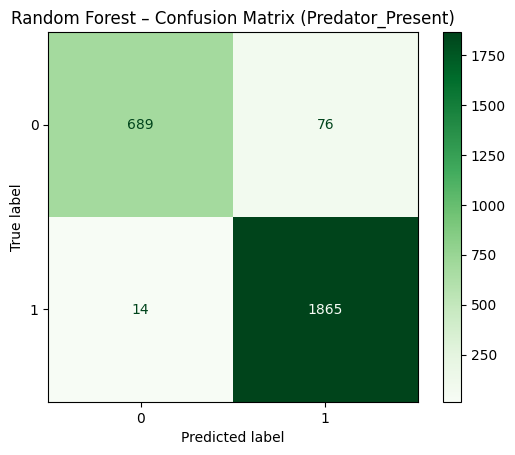

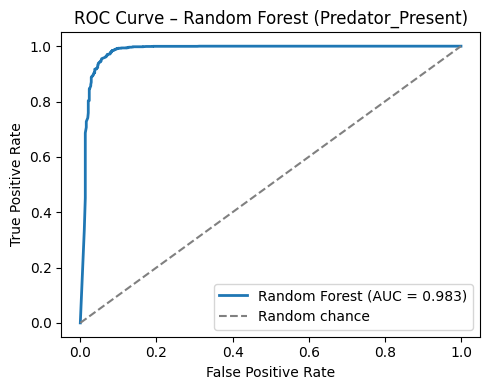

Top Random Forest Feature Importances:


,Feature,Importance
35,Survey_Direction_Unknown,0.134082
1,Air_Temp_degF,0.104085
3,Cloud_Cover,0.096788
4,Wind_Spd_mph,0.095432
2,Rel_Hum_per,0.094758
5,Wind_Max_mph,0.093639
6,Month,0.056369
31,Tide_Cond_Unknown,0.037721
0,Total_SNPL,0.032737
26,Tide_Cond_Lo-Slack,0.026904


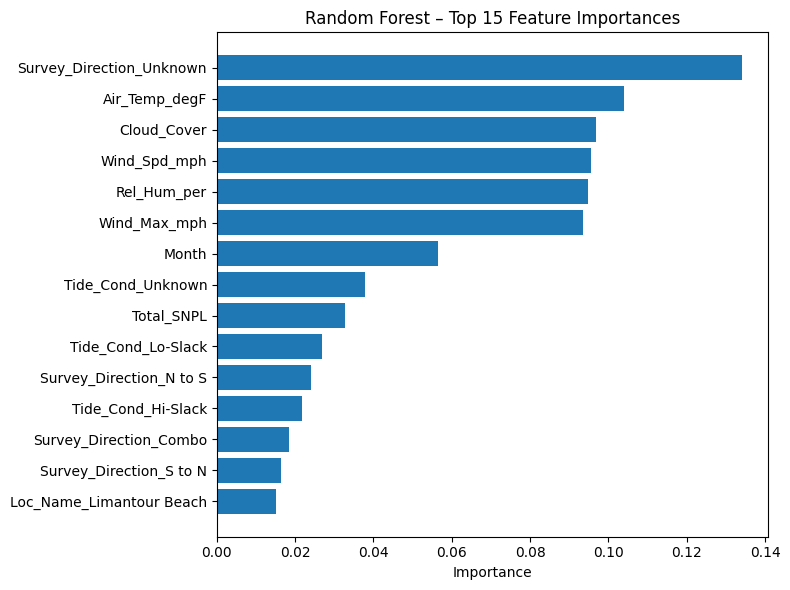

In [28]:
# Confusion matrix

cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=[0, 1])
plt.figure(figsize=(4, 4))
disp_rf.plot(values_format="d", cmap="Greens")
plt.title("Random Forest – Confusion Matrix (Predator_Present)")
plt.show()

# ROC curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(5, 4))
plt.plot(fpr_rf, tpr_rf, linewidth=2, label=f"Random Forest (AUC = {rf_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest (Predator_Present)")
plt.legend()
plt.tight_layout()
plt.show()

# Feaure importance

ohe = rf_best.named_steps["preprocess"].named_transformers_["cat"]["onehot"] # We need to get the feature names after preprocessing:
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

rf_inner = rf_best.named_steps["rf"]
importances = rf_inner.feature_importances_

feat_importances = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("Top Random Forest Feature Importances:")
display(feat_importances.head(15))

plt.figure(figsize=(8, 6))
plt.barh(feat_importances["Feature"].head(15), feat_importances["Importance"].head(15))
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Random Forest – Top 15 Feature Importances")
plt.tight_layout()
plt.show()

# Decision Tree Classifier
* Use because it also can capture non linear pattern
* Faster to train and tune so we can compare it to the random forest and see if we get better results
* Produces rule based decisions that are easy to visualize and understand, since it shows what features are useful

####Performance Analysis
* Accuracy: 95.99%
*Precision: 96.24%

* Recall: 98.19%

* F1 Score: 97.21%

* Cross-Validation Accuracy: ~95.26%

* The Decision Tree performs extremely well overall, achieving high accuracy while still maintaining good precision and recall for the predator-present class. It captures important patterns but still shows signs of slight overfitting compared to the Random Forest.

####Confusion Matrix
* True Negatives (693): Events correctly labeled as no predator

* True Positives (1845): Predator-present events correctly identified

* False Positives (72): Slight overprediction of predators

* False Negatives (34): Missed predator-present cases — more than Random Forest but still low

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Optimal hyperparameters for Decision Tree: {'dt__min_samples_split': 2, 'dt__min_samples_leaf': 1, 'dt__max_depth': None, 'dt__criterion': 'gini'}
Best CV accuracy (Decision Tree): 0.9526288505454336
Decision Tree – Test Performance
Accuracy:  0.959909228441755
Precision: 0.9624413145539906
Recall:    0.9819052687599787
F1 Score:  0.9720758693361433

Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       765
           1       0.96      0.98      0.97      1879

    accuracy                           0.96      2644
   macro avg       0.96      0.94      0.95      2644
weighted avg       0.96      0.96      0.96      2644



<Figure size 400x400 with 0 Axes>

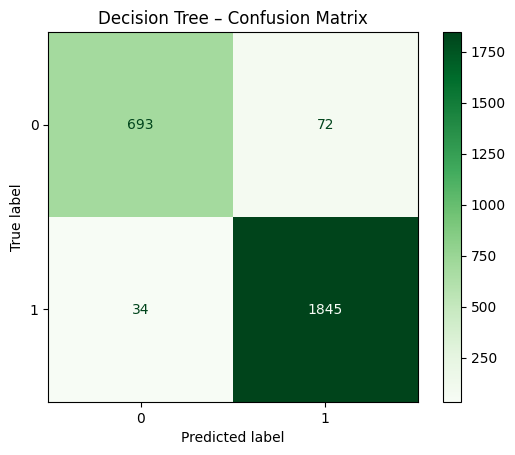

In [36]:
# Define hyperparameters
param_dist = {
    'dt__max_depth': [None, 5, 10, 20],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 5],
    'dt__criterion': ["gini", "entropy"]
}

# Decision tree estimator
dt = DecisionTreeClassifier(random_state=42)

# Build pipeline that applies all preprocessing steps, prevents data leakage
dt_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('dt', dt)
])

# 5 fold cross validation

dt_search = RandomizedSearchCV(
    estimator=dt_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit to training data
dt_search.fit(X_train, y_train)

# Best model and cross validation accuracy
print("Optimal hyperparameters for Decision Tree:", dt_search.best_params_)
print("Best CV accuracy (Decision Tree):", dt_search.best_score_)

# Get best estimator
best_dt = dt_search.best_estimator_

# Evaluate on test set
dt_pred = best_dt.predict(X_test)

print("Decision Tree – Test Performance")
print("Accuracy: ", accuracy_score(y_test, dt_pred))
print("Precision:", precision_score(y_test, dt_pred))
print("Recall:   ", recall_score(y_test, dt_pred))
print("F1 Score: ", f1_score(y_test, dt_pred))

print("\nClassification Report (Decision Tree):")
print(classification_report(y_test, dt_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, dt_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

plt.figure(figsize=(4,4))
disp.plot(values_format='d', cmap='Greens')
plt.title("Decision Tree – Confusion Matrix")
plt.show()


### Decision Tree Visualization


*   Split based on the most important feature, Survey_Direction_Unknown
*   Shows that predator presence can be determined using a small number of major conditions, environmental and location features play a role as well



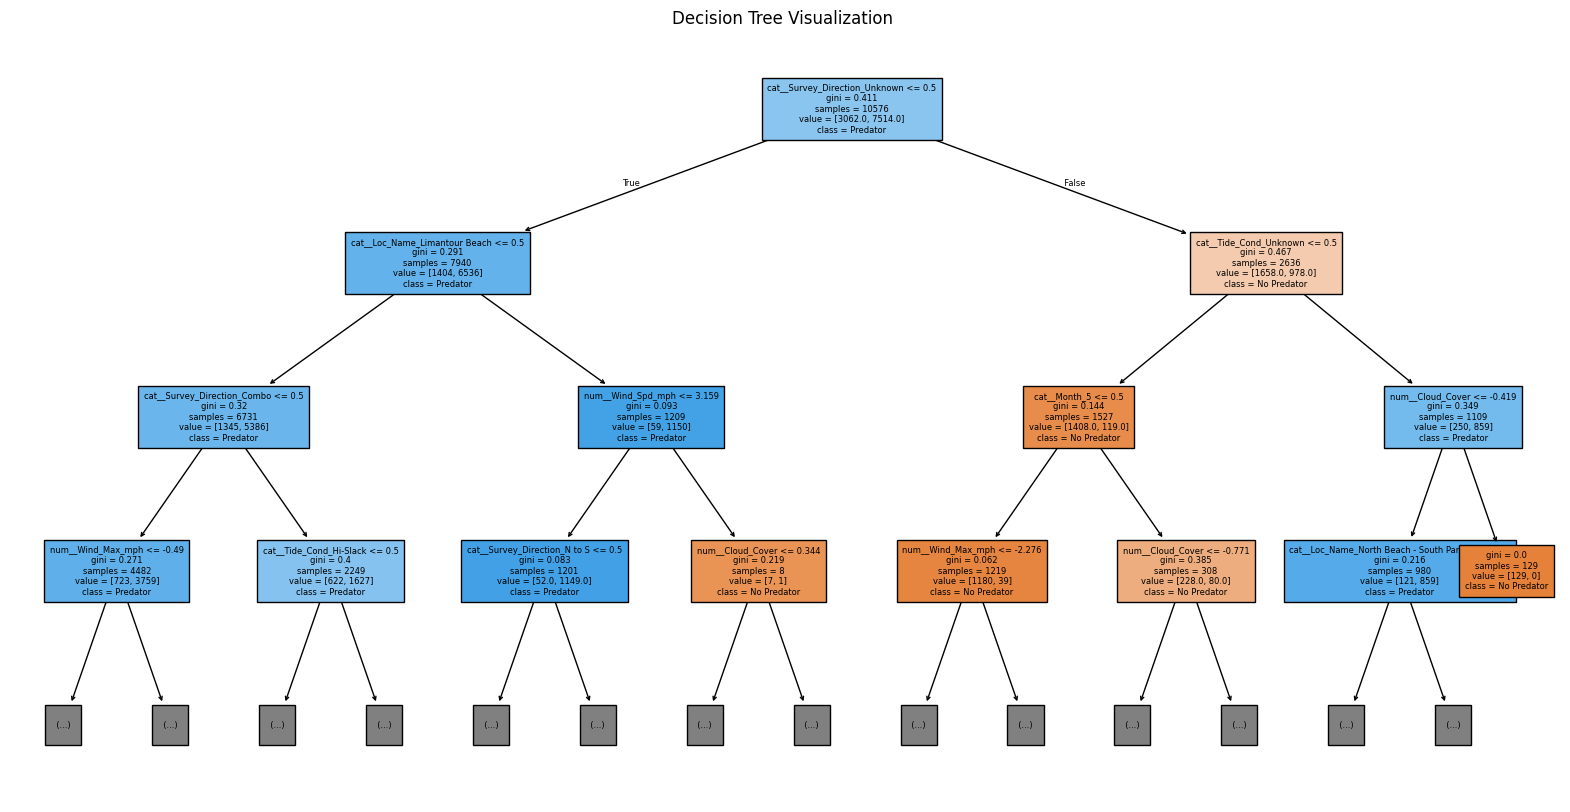

In [45]:
from sklearn.tree import plot_tree

# Get the trained tree
dt_inner = best_dt.named_steps['dt']

# Plot the decision tree (very simple)
plt.figure(figsize=(20, 10))
plot_tree(dt_inner,
          filled=True,
          feature_names=best_dt.named_steps['preprocess'].get_feature_names_out(),
          class_names=["No Predator", "Predator"],
          max_depth=3,
          fontsize=6)
plt.title("Decision Tree Visualization ")
plt.show()


# Compare Model Accuracy Scores


*  Logistic Regression:	0.839259
* Decision Tree:	0.959909
* Random Forest:	0.965961

*  Random forest has the highest accuracy score, so it will be chosen for the test set



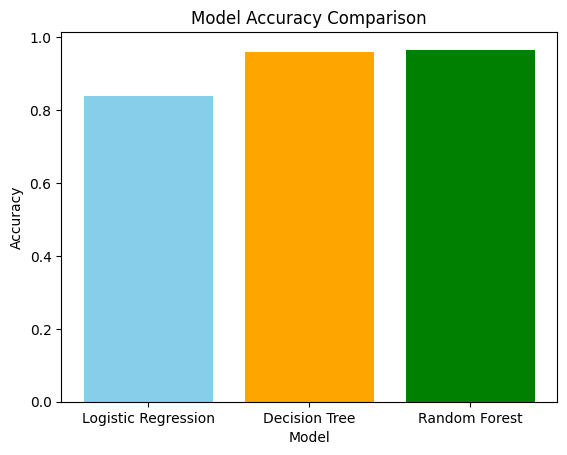

,Model,Accuracy
0,Logistic Regression,0.839259
1,Decision Tree,0.959909
2,Random Forest,0.965961


In [40]:
# Logistic Regression predictions
log_pred = best_log.predict(X_test)

# Decision Tree predictions
dt_pred = best_dt.predict(X_test)

# Random Forest predictions
rf_pred = rf_best.predict(X_test)

# Build a dataframe with all model accuracy scores
accuracy_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, log_pred),   # logistic regression accuracy
        accuracy_score(y_test, dt_pred),    # decision tree accuracy
        accuracy_score(y_test, rf_pred)     # random forest accuracy
    ]
})

# Plot the model comparison
plt.bar(accuracy_df['Model'], accuracy_df['Accuracy'],color=['skyblue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

accuracy_df

# Test Best ML Model on the Test Set

#### We chose random forest as the final model because it had the highest overall accuracy and a strong recall for the positive class. The feature importance metrics also showed that it had actionable ecological insights.

####Final Test Metrics
* Accuracy = 0.9659 --> Model correctly predicts predator presence or absence about 97% of the time

* Precision = 0.9608 --> When predicting if present, 96% time it is correct

* Recall = 0.9925 --> The model detects nearly all true predator observations—critical for conservation use

* F1-Score = 0.9764 --> Balanced performance between precision and recall, so it's a very high-quality classifier.

* AUC = 0.9826 --> Good ability to rank predator vs. non-predator conditions, excellent separation between the classes.

####Confusion Matrix
* True Positives (1 --> 1): 1865 --> The model correctly identifies predator presence in almost all cases

* True Negatives (0 --> 0): 689 --> The model also identifies many non-predator observations correctly

* False Positives (0 --> 1): 76 --> Slight over-prediction of predator presence but it's acceptable because false positives are less harmful than false negatives in ecological monitoring

* False Negatives (1 --> 0): 14 --> Very few missed predator cases

####Overall, this will help will supporting nest protection decisions and validates ecological hypotheses about predator activity patterns. The classifier also emphasizes clear predictive values for when and where snowy plovers face higher predatory risks, which can help guide resource allocation for habitat monitoring

Final Test Set Evaluation – Random Forest
Accuracy: 0.9659606656580938
Precision: 0.9608449252962391
Recall: 0.9925492283129325
F1 Score: 0.9764397905759162
AUC: 0.9825588635312206

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       765
           1       0.96      0.99      0.98      1879

    accuracy                           0.97      2644
   macro avg       0.97      0.95      0.96      2644
weighted avg       0.97      0.97      0.97      2644



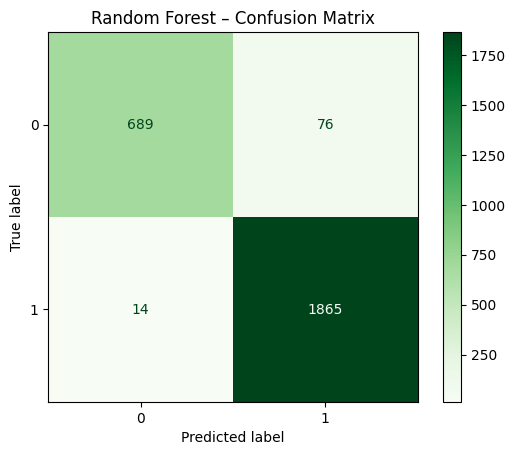

In [41]:
# Final evaluation using best model (Random Forest)
rf_pred = rf_best.predict(X_test)
rf_proba = rf_best.predict_proba(X_test)[:, 1]

print("Final Test Set Evaluation – Random Forest")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("Precision:", precision_score(y_test, rf_pred))
print("Recall:", recall_score(y_test, rf_pred))
print("F1 Score:", f1_score(y_test, rf_pred))

rf_auc = roc_auc_score(y_test, rf_proba)
print("AUC:", rf_auc)

print("\nClassification Report:\n")
print(classification_report(y_test, rf_pred))

cm = confusion_matrix(y_test, rf_pred)
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(cmap="Greens")
plt.title("Random Forest – Confusion Matrix")
plt.show()
